# Pytorch Chatbot 代码学习
代码来源：https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import pdb
import math


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

## 打印数据文件，用于查看

后面会多次用到这个函数来展示一些函数的结果

In [2]:
corpus_name = "cornell_movie-dialogs_corpus"
corpus = os.path.join("../data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


# 创建格式化数据文件

The following functions facilitate the parsing of the raw *movie_lines.txt* data file.
以下函数用于解析*movie_lines.txt*中的每一行数据：

- `loadLines` 分割一行，并存为字典格式 (lineID, characterID, movieID, character, text)
- `loadConversations` 将*movie_conversations.txt*读取后，最后根据最后一列的LineId关联append具体的Line
- `extractSentencePairs` 只抽取出句子对，不管其他信息, lineID, characterID, movieID, character 全不要

In [3]:
# Splits each line of the file into a dictionary of fields  操作："movie_lines.txt"
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):    
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f: 
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            lineIds = eval(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                 qa_pairs.append([inputLine, targetLine])
    return qa_pairs

## 数据处理
处理好数据，保存为一个新的数据文件 "formatted_movie_lines.txt" ，里面每行记录是两个句子，句子间用 "\t" 间隔

In [4]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter)
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\r\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\r\r\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser. 

## 制作词汇表

定义了一个 `Voc` 字典类，主要目的是：

- 从词映射到词标，从词标映射到词
- 计算每个单词的频次，计算所有单词的数量

提供三种方法：

- 将一个词加入字典中     （`addWord`）
- 将一个句子中的所有词都加入字典中  (`addSentence`）
- 删除（修剪）字典中的低频词  (`trim`) ，修剪后的字典词出现的频次都变为1，所以只能修剪一次

In [5]:
# Default word tokens
PAD_token = 0  # 句子填充符号，将短句子边长，保证所有句子等长
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

## 几个补充操作

- 去除英文中的重音（accent）符号
- 让符号和单词别连着，只保留三种符号 ".!?"，栓出连续空格
- 删除过长的对话，是直接删除，不是剪短

In [7]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):   # 删除重音符号
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)    #用空格间隔文本符号与单词，英文中句子的最后一个单词后面是没有空格的，接的是标点符号
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)   # 删除除三个文本符号
    s = re.sub(r"\s+", r" ", s).strip()    #删除连续空格，只保留一个空格
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines if len(l.split('\t'))>1]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    if not (isinstance(p,list) and len(p)>1): pdb.set_trace()
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


## 删除包含非常用词的句子对

删除很少出现的词语（少见词）后，如果输入和输出都包含这些少见词，我们就这条训练记录删去，这样有利于模型的快速收敛，主要分为两个步骤：

- 使用 `Voc` 字典类中的修剪方法（`voc.trim`），将词频小于 `MIN_COUNT`的单词删去
- 如果一个句子对中两个句子均包含少见词，我们把这个句子中数据集合中删去

In [8]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


## 准备真正的模型数据

我们需要使用GPU加速模型，所以需要每次按照batch_size 传入数据，第n个时间步，我们传入的不是第n个句子，而是所有batch_size个句子的中的第n个词， 所以我们需要将传入的数据shape转置，从(batch_size,max_length) -->(max_length,batch_size)，所以我们定义了以下这些函数：

每个batch的句子对分为input sentences 和 output sentence
- `inputVar`: 把传入的一个batch的input sentences转为词标，并把每行填充到等长，记录每行的句子长度lengths，并转为torch.tensor格式

- `outputVar` 实现了类似的功能，但是不同于`inputVar`返回句子长度lengths，这个功能返回的是同样shape的二进制矩阵mask来记录那些位置是非padding词，以此记录句子长度

- `batch2TrainData` simply takes a bunch of pairs and returns the input and target tensors using the aforementioned functions.

### 一些小技巧：

`random.choice(seq)`: 方法返回一个列表，元组或字符串的随机项。

`list.sort()`: pair_batch是一个list数据，pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

`itertools.zip_longest(a,b,.. fillvalue=fillvalue)`: 按照最长的序列的长度末尾填充短的list

In [14]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])  # 记录每一行的词数，变为tensor格式
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)    # 以Question字符数量从多到少排序
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 131,   50,  101,   50,  167],
        [1859,    6,   37,  623,    4],
        [   4,   50,   70,    6,    2],
        [  76,   47, 1082,    2,    0],
        [  37,    7,    4,    0,    0],
        [  12,  260,    2,    0,    0],
        [3078,    6,    0,    0,    0],
        [   4,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 8, 6, 4, 3])
target_variable: tensor([[  12,   92,   62,   53,  115],
        [3078,    7,  519,  574,   36],
        [   6, 4294, 2000,  623,   38],
        [   2,  169,   76,    4,    7],
        [   0,  208,    4,    2,    8],
        [   0, 2411,    2,    0,   40],
        [   0,    6,    0,    0,   41],
        [   0,    2,    0,    0,    6],
        [   0,    0,    0,    0,    2]])
mask: tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 0, 0, 1],
        [0, 1, 0, 0, 1],
      

# 实现编码器

参考：https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-custom-nn-modules

- 继承nn.Module类

- 重构函数forward 以获得输入张量和得到输出结果

说明：我们只需要定义网络模型前向过程的结构，后向的梯度传播已经有`torch.autograd`实现，不需要我们定义

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

## Decoder
加入了注意力机制的Decoder，教程提到的两种注意力机制：BahdanauAttention与LuongAttention的详细介绍参考下面链接：

[BahdanauAttention与LuongAttention注意力机制简介](https://blog.csdn.net/u010960155/article/details/82853632)

这里提到的三种方法：
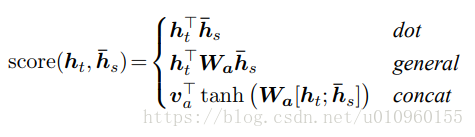

是LuongAttention中的三种对齐函数

In [20]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [21]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

## 定义模型的loss

`torch.view`：就是numpy.reshape

`torch.gather(input, dim, index, out=None)`: 

In [22]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

## 开始训练

使用两个训练技巧帮助模型收敛：

- `teacher forcing`：在训练时，以一定的概率(teacher_forcing_ratio)使用当前目标词作为解码器的下一个输入，而不是使用解码器的当前猜测词，
值得注意的是，使用目标词来训练解码很容易造成模型不问的那个 ，所以要设置合适的概率值

- `gradient clipping`：称为梯度裁剪，是用于解决梯度爆炸问题

In [23]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [ ]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [ ]:
## 定义评估器


In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores